In [7]:
import numpy as np
from matplotlib import pyplot as plt
from ts_modelling import data_producer
from ts_modelling.simple_experiment import SimpleExp
from argparse import Namespace
import yaml
with open('args.yaml', 'r') as file:
    config = yaml.safe_load(file)
args = Namespace(**config)
exp = SimpleExp(args)

from data_producer import DataProducer
dp = DataProducer(length=5000, n_vars=1, path=args.root_path)
dp.add_sine(freq_amp=[(1,2)])
dp.add_trend(3, 0.05)
%matplotlib inline

Use CPU


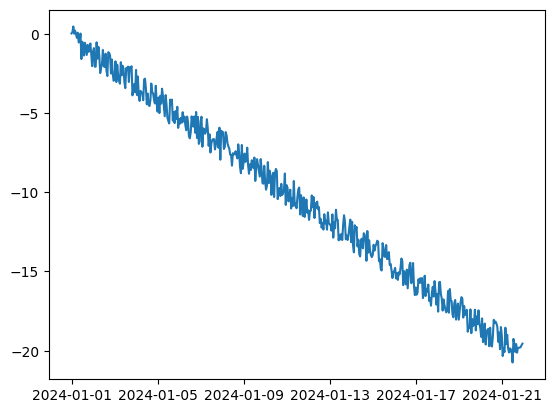

In [10]:
dp.create_df()
plt.plot(dp.df['date'][:24*7*3], dp.df.iloc[:24*7*3, 1:])

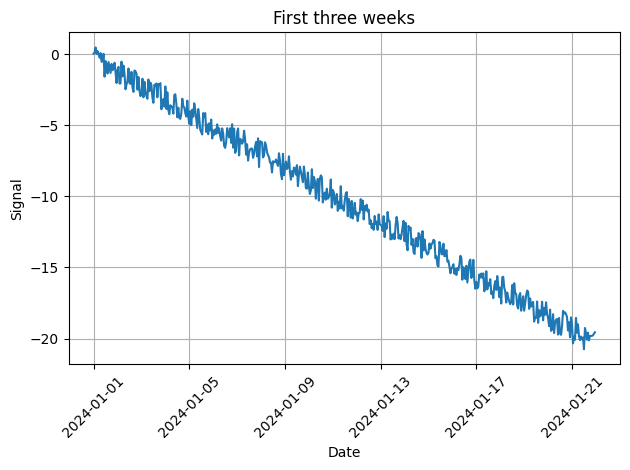

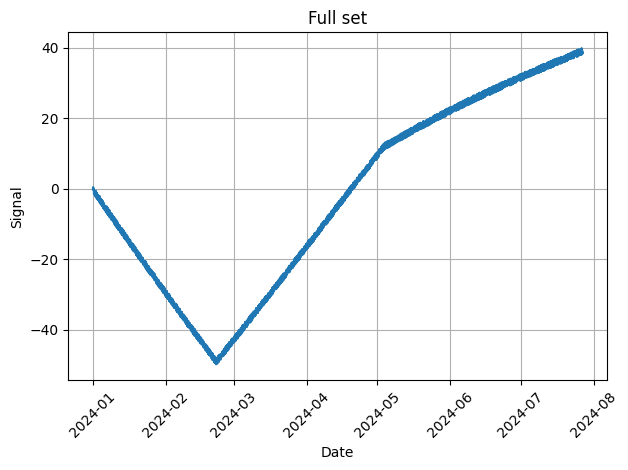

In [12]:
dp.plot_data()